<a href="https://colab.research.google.com/github/Aakash326/ML-models/blob/main/sports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-06-16 15:21:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-16 15:21:15 (93.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
import helper_functions

In [3]:
from helper_functions import make_confusion_matrix, create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [4]:
from google.colab import files
uploaded = files.upload()


Saving sports.zip to sports.zip


In [5]:
import zipfile
zip_ref=zipfile.ZipFile("/content/sports.zip")
zip_ref.extractall()
zip_ref.close()

In [7]:
unzip_data("/content/sports.zip")

In [9]:
walk_through_dir("/content/Users/saiaakash/Desktop/archive")

There are 3 directories and 2 images in '/content/Users/saiaakash/Desktop/archive'.
There are 100 directories and 0 images in '/content/Users/saiaakash/Desktop/archive/test'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/sailboat racing'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/wheelchair basketball'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/hurdles'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/figure skating men'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/rowing'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/surfing'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/figure skating women'.
There are 0 directories and 5 images in '/content/Users/saiaakash/Desktop/archive/test/speed skating'

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_images_grid(target_dir, target_class, n_images=9):
    # Setup the target directory
    target_folder = os.path.join(target_dir, target_class)

    # List all image files in the folder
    image_filenames = os.listdir(target_folder)

    # Safety check: don't sample more images than available
    n_images = min(n_images, len(image_filenames))

    # Pick random images
    random_images = random.sample(image_filenames, n_images)

    # Setup the plot grid (square root for a grid shape)
    grid_size = int(n_images ** 0.5)
    if grid_size ** 2 < n_images:
        grid_size += 1

    # Plot
    plt.figure(figsize=(grid_size * 3, grid_size * 3))

    for i, image_filename in enumerate(random_images):
        img = mpimg.imread(os.path.join(target_folder, image_filename))

        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img)
        plt.title(f"{target_class}\n{image_filename}", fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print(f"Displayed {n_images} random images from class '{target_class}'.")

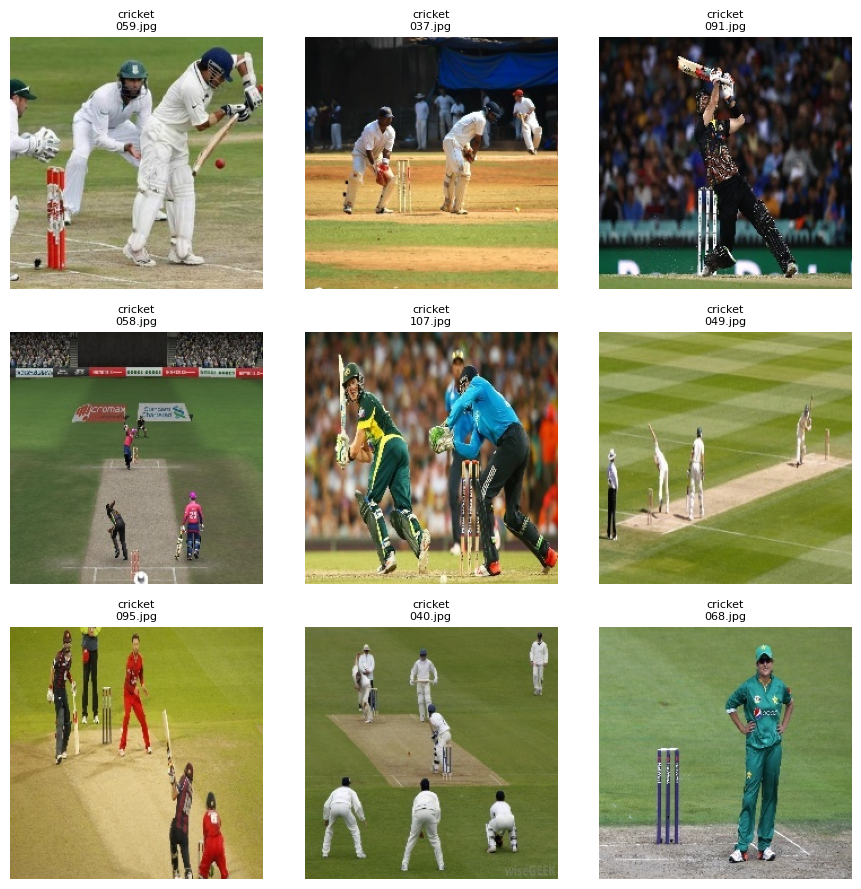

Displayed 9 random images from class 'cricket'.


In [13]:
view_random_images_grid(target_dir="/content/Users/saiaakash/Desktop/archive/train", target_class="cricket")

In [17]:
train_dir="/content/Users/saiaakash/Desktop/archive/train"
test_dir="/content/Users/saiaakash/Desktop/archive/test"
val_dir="/content/Users/saiaakash/Desktop/archive/valid"

In [48]:
import tensorflow as tf
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    label_mode="categorical"
)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(224,224),
    label_mode="categorical"
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    label_mode="categorical"
)

Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [49]:
class_names = train_data.class_names

In [20]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras.layers import RandomFlip,RandomHeight,RandomWidth,RandomZoom,RandomRotation,RandomContrast,RandomBrightness
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
data_agu=Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),  # Reduced rotation
        RandomZoom(0.1),
        RandomHeight(0.1),
        RandomWidth(0.1),
        # RandomContrast(0.1),
        # RandomBrightness(0.1),

])

In [26]:
input_size=(224,224,3)
base_model = tf.keras.applications.EfficientNetB2(
    include_top=False,
    weights='imagenet',
    input_shape=input_size
)
base_model.trainable=False
inputs=layers.Input(shape=input_size,name="input_layer")
x=data_agu(inputs)
x=base_model(x,training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Simplified and improved head
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# outputs=tf.keras.layers.Dense(len(train_data),activation="softmax",name="output_layer")(x)
outputs=tf.keras.layers.Dense(100,activation="softmax",name="output_layer")(x)
model=tf.keras.Model(inputs,outputs)

In [28]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [32]:
initial_epochs=10

In [30]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

    # Get class distribution
y_train = []
for _, labels in train_data:
    y_train.extend(tf.argmax(labels, axis=1).numpy())

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.2046428571428571), 1: np.float64(1.2046428571428571), 2: np.float64(1.0221212121212122), 3: np.float64(1.3628282828282827), 4: np.float64(1.1939823008849557), 5: np.float64(0.9178231292517007), 6: np.float64(1.096910569105691), 7: np.float64(0.7754022988505748), 8: np.float64(0.7983431952662722), 9: np.float64(1.2492592592592593), 10: np.float64(1.2265454545454546), 11: np.float64(0.9304827586206896), 12: np.float64(0.9637142857142857), 13: np.float64(0.9776811594202899), 14: np.float64(1.1243333333333334), 15: np.float64(1.163103448275862), 16: np.float64(0.905503355704698), 17: np.float64(1.07936), 18: np.float64(0.8226829268292682), 19: np.float64(1.0299236641221374), 20: np.float64(1.1243333333333334), 21: np.float64(1.0458914728682172), 22: np.float64(1.006865671641791), 23: np.float64(0.9568794326241135), 24: np.float64(1.096910569105691), 25: np.float64(0.9994074074074074), 26: np.float64(0.8593630573248408), 27: np.float64(1.0540625), 28: np.floa

In [33]:
model.fit(train_data,epochs=initial_epochs,steps_per_epoch=int(0.1 * len(train_data)),validation_data=val_data,validation_steps=int(0.1 * len(val_data)))

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 276ms/step - accuracy: 0.3594 - loss: 2.5127 - val_accuracy: 0.8125 - val_loss: 0.4776
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.4143 - loss: 2.2179 - val_accuracy: 0.8438 - val_loss: 0.6557
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.4474 - loss: 2.1204 - val_accuracy: 0.8125 - val_loss: 0.7562
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.4858 - loss: 1.9126 - val_accuracy: 0.7188 - val_loss: 0.8530
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.5091 - loss: 1.8716 - val_accuracy: 0.8750 - val_loss: 0.5452
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.5520 - loss: 1.6398 - val_accuracy: 0.6875 - val_loss: 1.0557
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.5542 - loss: 1.6141 - val_accuracy: 0.8750 - val_loss: 0.7122
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.5836 - loss: 1.5328 - val_accuracy

In [34]:
model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8820 - loss: 0.4846


[0.46983131766319275, 0.8899999856948853]

In [31]:
base_model.trainable = True

# Freeze early layers (keep 80% frozen)
total_layers = len(base_model.layers)
freeze_until = int(total_layers * 0.8)

for i, layer in enumerate(base_model.layers):
    if i < freeze_until:
        layer.trainable = False
    else:
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
final_epochs=initial_epochs+7

In [38]:
model.fit(train_data,epochs=final_epochs,steps_per_epoch=len(train_data),validation_data=val_data,validation_steps=int(0.2 * len(val_data)),initial_epoch=initial_epochs)

Epoch 11/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 66s 156ms/step - accuracy: 0.7524 - loss: 0.8809 - val_accuracy: 0.9271 - val_loss: 0.2246
Epoch 12/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.7982 - loss: 0.7204 - val_accuracy: 0.9688 - val_loss: 0.1452
Epoch 13/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8194 - loss: 0.6425 - val_accuracy: 0.9688 - val_loss: 0.1402
Epoch 14/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 194ms/step - accuracy: 0.8337 - loss: 0.5781 - val_accuracy: 0.9375 - val_loss: 0.1691
Epoch 15/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 65s 154ms/step - accuracy: 0.8597 - loss: 0.4918 - val_accuracy: 0.9792 - val_loss: 0.1180
Epoch 16/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 150ms/step - accuracy: 0.8711 - loss: 0.4452 - val_accuracy: 0.9792 - val_loss: 0.1025
Epoch 17/17
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 147ms/step - accuracy: 0.8916 - loss: 0.4012 - val_accuracy: 0.9062 - val_loss: 0.2544


In [39]:
model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9719 - loss: 0.0952


[0.08098138868808746, 0.9700000286102295]

Saving Screenshot 2025-06-16 at 9.58.25 PM.png to Screenshot 2025-06-16 at 9.58.25 PM (4).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


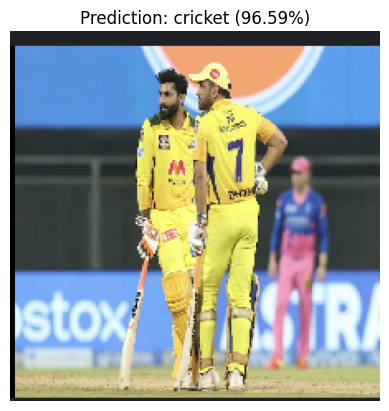

Predicted class: cricket
Confidence: 96.59%


In [52]:
from google.colab import files
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess image
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

img_array = tf.expand_dims(img_array, axis=0)  # Add batch dim
img_array = preprocess_input(img_array)        # Normalize for EfficientNet

# Step 3: Make prediction
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()
confidence = tf.reduce_max(predictions[0]).numpy()

# Step 4: Get class names (from dataset)
# Assuming the original dataset used to create train_data has a class_names attribute
# Replace 'original_dataset' with the actual variable name of your dataset
# class_names = train_data.element_spec[0].shape[-1]
# class_names = target_class # Using the class_name variable from cell np1_qQ5RREVI
# class_names = ds_info.features["label"].names


# Step 5: Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[int(predicted_class)]} ({confidence*100:.2f}%)") # Convert predicted_class to int
plt.show()

print(f"Predicted class: {class_names[int(predicted_class)]}") # Convert predicted_class to int
print(f"Confidence: {confidence*100:.2f}%")

Saving Screenshot 2025-06-16 at 10.05.15 PM.png to Screenshot 2025-06-16 at 10.05.15 PM.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


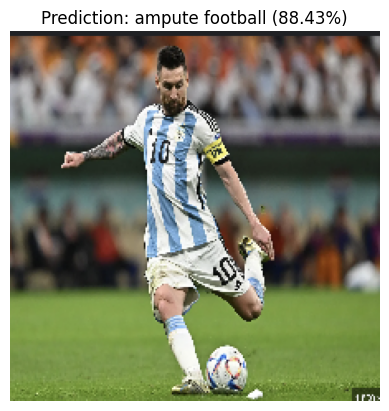

Predicted class: ampute football
Confidence: 88.43%


In [53]:
from google.colab import files
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Step 2: Load and preprocess image
# img = image.load_img(img_path, target_size=(224, 224))
# img_array = image.img_to_array(img)
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)

img_array = tf.expand_dims(img_array, axis=0)  # Add batch dim
img_array = preprocess_input(img_array)        # Normalize for EfficientNet

# Step 3: Make prediction
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0]).numpy()
confidence = tf.reduce_max(predictions[0]).numpy()

# Step 4: Get class names (from dataset)
# Assuming the original dataset used to create train_data has a class_names attribute
# Replace 'original_dataset' with the actual variable name of your dataset
# class_names = train_data.element_spec[0].shape[-1]
# class_names = target_class # Using the class_name variable from cell np1_qQ5RREVI
# class_names = ds_info.features["label"].names

# Step 5: Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {class_names[int(predicted_class)]} ({confidence*100:.2f}%)") # Convert predicted_class to int
plt.show()

print(f"Predicted class: {class_names[int(predicted_class)]}") # Convert predicted_class to int
print(f"Confidence: {confidence*100:.2f}%")

In [45]:
model.save("Sports_img_classification.h5")